In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## One-day-ahead prediction model ##

- Use time series data to build a model and predict the next day covid new cases

**LSTM model**

In [2]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [3]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [4]:
# load the dataset
covid_data = read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv')
covid_data['shift1'] = covid_data['cases'].shift(1)
covid_data['daily cases'] = covid_data['cases'] - covid_data['shift1']
covid_data.loc[0, 'daily cases'] = 1
covid_data['daily cases 7day avg'] = covid_data['daily cases'].rolling(7).mean()

# mannualy compute daily cases 7day avg for the first 6 days
covid_data.loc[0:6, 'daily cases 7day avg'] = covid_data.loc[0:6, 'cases'] / 7
dataset = covid_data['daily cases 7day avg'].values.reshape(-1, 1)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [5]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=32, verbose=2)

Epoch 1/100
27/27 - 2s - loss: 0.0183
Epoch 2/100
27/27 - 0s - loss: 0.0069
Epoch 3/100
27/27 - 0s - loss: 0.0041
Epoch 4/100
27/27 - 0s - loss: 0.0029
Epoch 5/100
27/27 - 0s - loss: 0.0024
Epoch 6/100
27/27 - 0s - loss: 0.0023
Epoch 7/100
27/27 - 0s - loss: 0.0022
Epoch 8/100
27/27 - 0s - loss: 0.0021
Epoch 9/100
27/27 - 0s - loss: 0.0020
Epoch 10/100
27/27 - 0s - loss: 0.0018
Epoch 11/100
27/27 - 0s - loss: 0.0018
Epoch 12/100
27/27 - 0s - loss: 0.0017
Epoch 13/100
27/27 - 0s - loss: 0.0015
Epoch 14/100
27/27 - 0s - loss: 0.0014
Epoch 15/100
27/27 - 0s - loss: 0.0014
Epoch 16/100
27/27 - 0s - loss: 0.0012
Epoch 17/100
27/27 - 0s - loss: 0.0011
Epoch 18/100
27/27 - 0s - loss: 0.0011
Epoch 19/100
27/27 - 0s - loss: 9.6766e-04
Epoch 20/100
27/27 - 0s - loss: 8.6352e-04
Epoch 21/100
27/27 - 0s - loss: 7.6314e-04
Epoch 22/100
27/27 - 0s - loss: 7.0190e-04
Epoch 23/100
27/27 - 0s - loss: 6.1346e-04
Epoch 24/100
27/27 - 0s - loss: 5.3839e-04
Epoch 25/100
27/27 - 0s - loss: 4.8303e-04
Epoch 

In [6]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

Train Score: 9114.99 RMSE
Test Score: 5100.93 RMSE


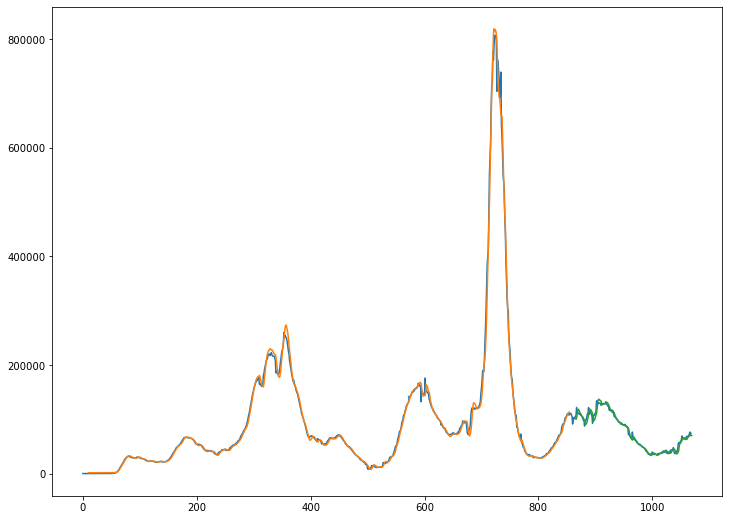

In [14]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(12, 9))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

**ARIMA model as baseline**

- need some work here

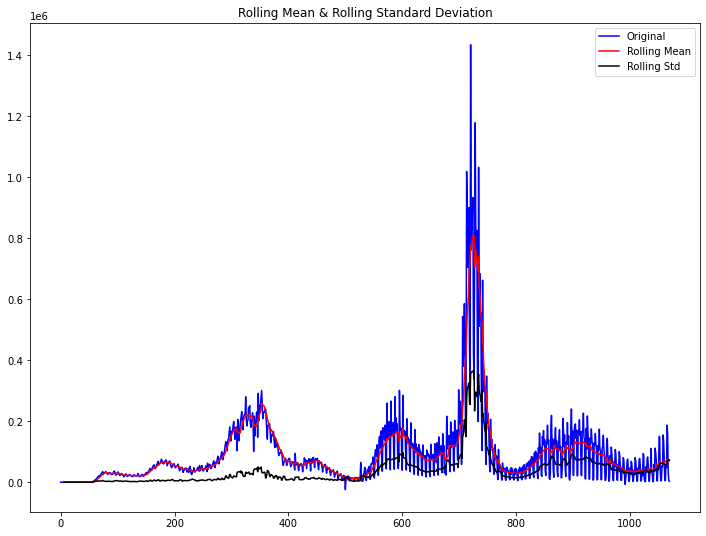

In [16]:
rolling_mean = covid_data['daily cases'].rolling(window = 7).mean()
rolling_std = covid_data['daily cases'].rolling(window = 7).std()
plt.figure(figsize=(12, 9))
plt.plot(covid_data['daily cases'], color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [17]:
result = adfuller(covid_data['daily cases'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -4.527664819361215
p-value: 0.0001752038898535764
Critical Values:
	1%: -3.436605142651622
	5%: -2.8643018096684587
	10%: -2.568240496510984
